In [1]:
from __future__ import print_function

import sys
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm


import copy

import numpy as np
import torch

from common.hvsmr.config import config_hvsmr
from in_out.hvsmr.load_data import HVSMR2016DataSet
from plotting.color_maps import transparent_cmap
from utils.hvsmr.batch_handler import HVSMRTwoDimBatchHandler
from utils.hvsmr.experiment import HVSMRExperiment as Experiment
from utils.hvsmr.exper_handler import HVSMRExperimentHandler as ExperimentHandler
from utils.hvsmr.test_handler import HVSMRTesthandler as TestHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs/HVSMR")

FOLD_ID = 0

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
dataset = HVSMR2016DataSet(config_hvsmr, search_mask=config_hvsmr.dflt_image_name + ".nii",
                               fold_id=FOLD_ID, preprocess="rescale",
                               debug=False, val_set_only=True)

In [2]:
test_handler = TestHandler(config_hvsmr, fold_id=FOLD_ID, use_cuda=True)

100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


In [2]:
exp_mc01_brier = {3: "",
                  2: "",
                  1: "",
                  0: "20180919_23_03_53_dcnn_hvsmr_mc_f0p01_brier_10KE_lr1e03"}

exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[FOLD_ID])

exper_hdl_mc01_brier = ExperimentHandler()
exper_hdl_mc01_brier.load_experiment(exp_mc01_brier_path, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name: {}".format(exper_hdl_mc01_brier.model_name))
print("-------------------------------------------------------------------------")

Load experiment from /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180919_23_03_53_dcnn_hvsmr_mc_f0p01_brier_10KE_lr1e03/stats/exper_stats.dll
Model name: dcnn_hvsmr_mc p=0.10 fold=0 loss=brier
-------------------------------------------------------------------------


In [8]:
exper_hdl_mc01_brier.test(10000, test_handler, image_num=1, mc_samples=1, sample_weights=False, 
                          compute_hd=False, store_details=False, do_filter=True, save_pred_labels=True,
                          store_test_results=False)

Image 2-patient010 - test loss 1636.963  dice(RV/Myo/LV):	 0.77/0.89	


In [10]:
exper_hdl_mc01_brier.create_entropy_maps(do_save=True)

INFO - Saved all entropy maps to /home/jorg/repository/dcnn_acdc/logs/HVSMR/20180919_23_03_53_dcnn_hvsmr_mc_f0p01_brier_10KE_lr1e03/u_maps


((193, 272), (193, 272))
((193, 272), (193, 272))
((193, 272), (193, 272))
((193, 272), (193, 272))
((193, 272), (193, 272))


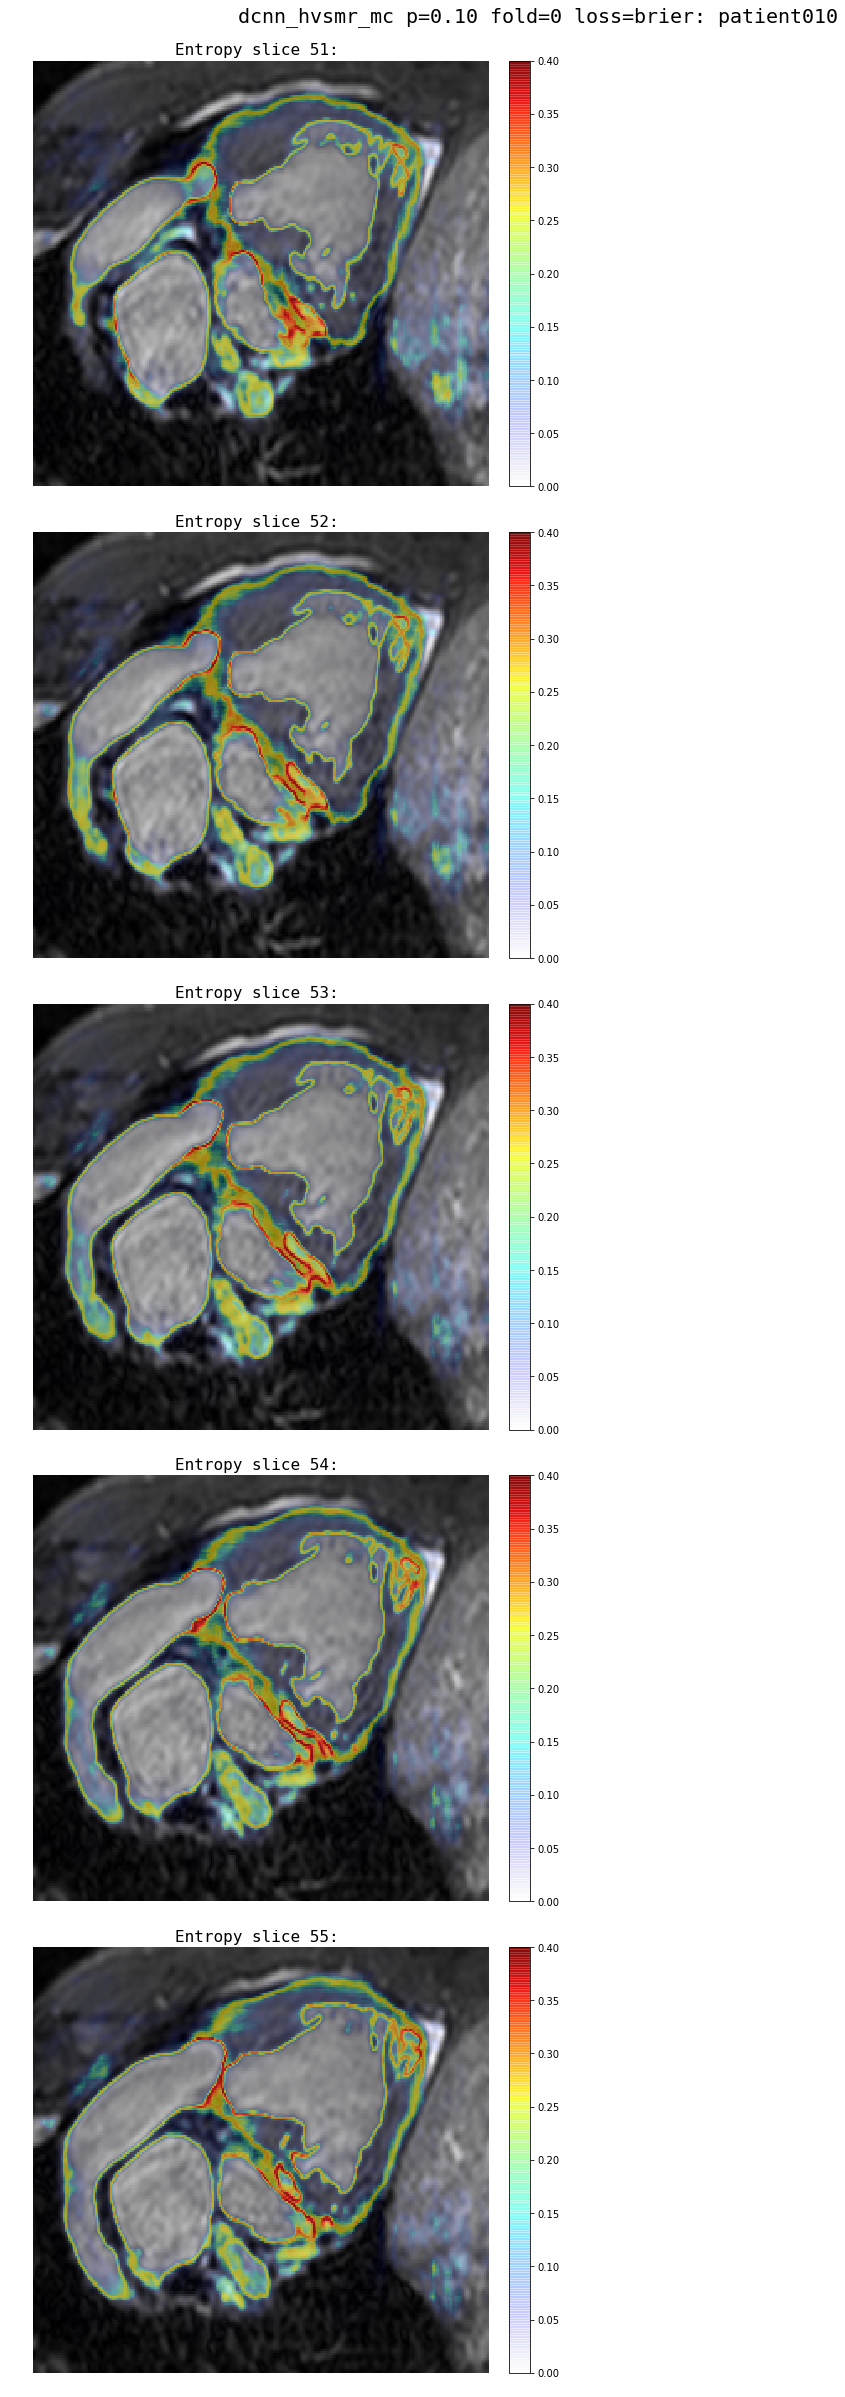

In [13]:
from plotting.entropy_map_plots import plot_entropy_map_for_patient

plot_entropy_map_for_patient(exper_hdl_mc01_brier, patient_id="patient010", do_show=True, do_save=False,
                             slice_range=np.arange(50, 55))

In [7]:
new_batch = HVSMRTwoDimBatchHandler(exper_hdl_mc01_brier.exper, batch_size=16)
new_batch.generate_batch_2d(dataset.train_images, dataset.train_labels,
                            num_of_slices=dataset.train_num_slices)

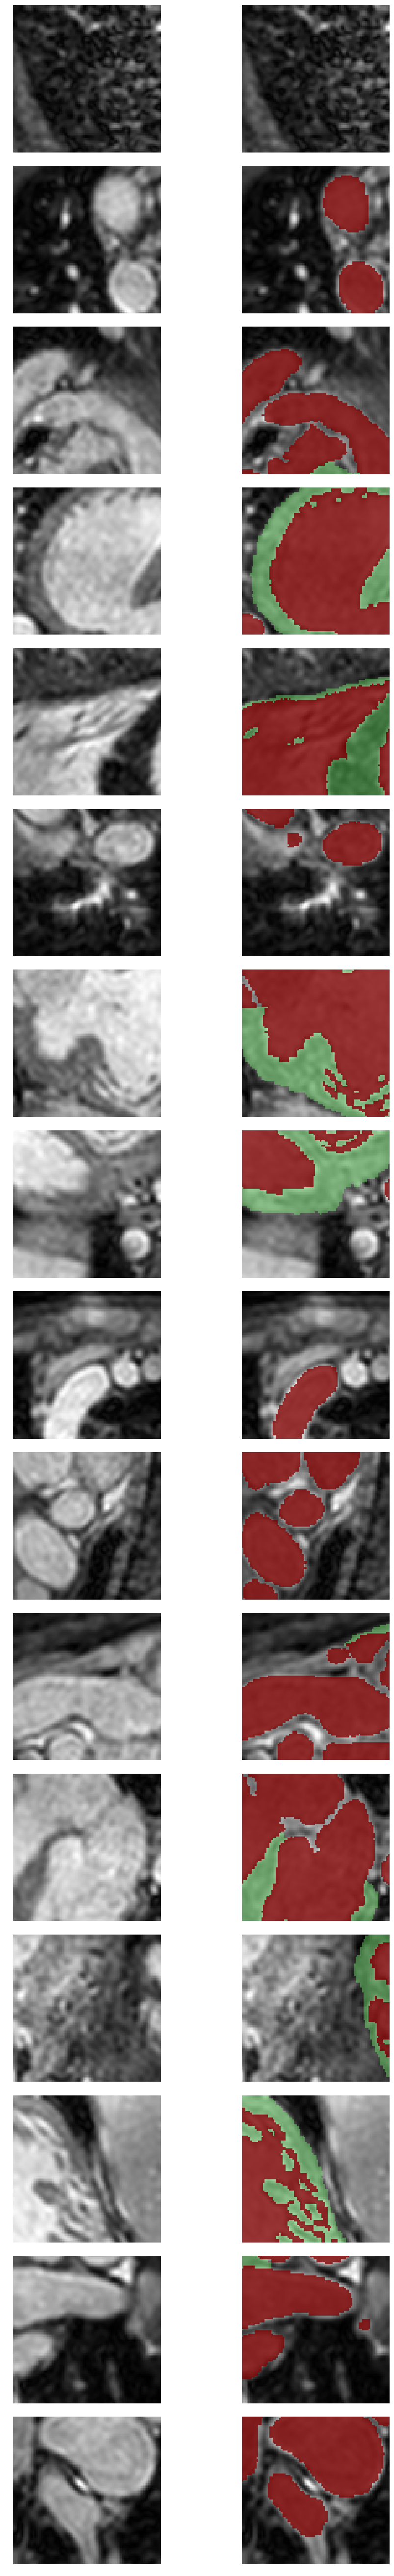

In [8]:
num_of_slices = dataset.get_num_of_slices(train=True)
batch_size = new_batch.batch_size
batch_offset = 0
width = 16
height = batch_size * 6
columns = 4
rows = batch_size * 2
column = 0
row = 0
fig = plt.figure(figsize=(width, height))

for idx in np.arange(batch_offset, batch_size):
    image_with_padding = new_batch.b_images[idx][0]
    image = HVSMR2016DataSet.remove_padding(image_with_padding)
    reference = new_batch.b_labels[idx]
    np_ref = reference.data.cpu().numpy()
    ax1 = plt.subplot2grid((rows, columns), (row, 0), rowspan=2, colspan=2)
    ax1.imshow(image, cmap=cm.gray)
    plt.axis("off")
    ax2 = plt.subplot2grid((rows, columns), (row, 2), rowspan=2, colspan=2)
    ax2.imshow(image, cmap=cm.gray)
    ax2.imshow(reference, cmap=mycmap)
    plt.axis("off")
    row += 2